In [1]:
import torch 
import torchvision
import torch.nn as nn #related functions for nn
import torch.optim as optim #defines optimiser
from torch.utils.data import Dataset, DataLoader #used for datasets
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
import timm #for loading architecture image classifications

import matplotlib.pyplot as plt #for data viz
import pandas as pd
import numpy as np
import sys

print("System Version:", sys.version)
print("Pytorch Version:", torch.__version__)
print("Torchvision version", torchvision.__version__)
print("Numpy Version", np.__version__)
print("Pandas version", pd.__version__)

System Version: 3.12.0 | packaged by conda-forge | (main, Oct  3 2023, 08:43:22) [GCC 12.3.0]
Pytorch Version: 2.9.1+cpu
Torchvision version 0.24.1+cpu
Numpy Version 2.3.4
Pandas version 2.3.3


Datasets

In [2]:
class VehicleImgDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]
    
    def classes(self):
        return self.data.classes

In [3]:
dataset = VehicleImgDataset(data_dir="/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/")

In [4]:
len(dataset)

14231

In [5]:
dataset[2500]

(<PIL.Image.Image image mode=RGB size=1280x720>, 0)

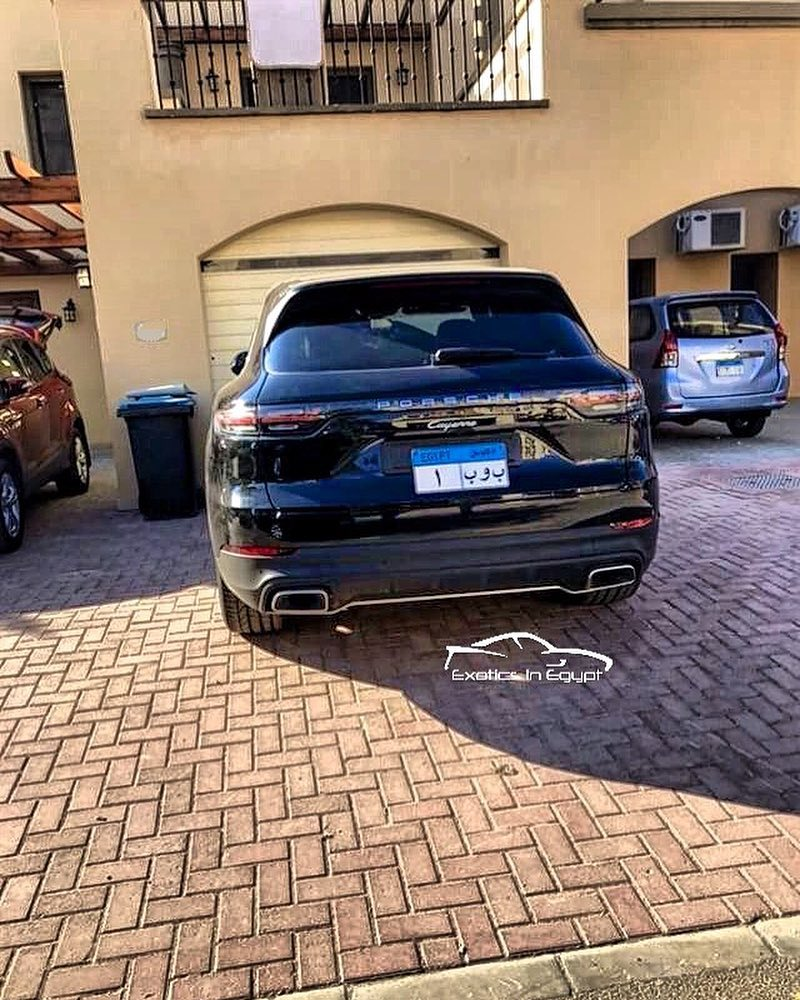

In [6]:
image, label = dataset[100]
image
#print(label)

In [7]:
data_dir = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/trainData"
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'Brazil', 1: 'Egypt', 2: 'Estonia', 3: 'Finland', 4: 'Kazakhstan', 5: 'Lithuania', 6: 'Serbia', 7: 'UAE', 8: 'UK', 9: 'USA'}


In [8]:
#IMAGE PREPROCESSING

transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor(),])

data_dir = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/trainData"
dataset = VehicleImgDataset(data_dir, transform)

In [9]:
image, label = dataset[1000]
image.shape

#torch.Size([colour-channels, height, width])

torch.Size([3, 128, 128])

DataLoaders

In [10]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in dataloader:
    break

images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [12]:
labels

tensor([9, 1, 9, 9, 1, 1, 9, 9, 9, 9, 8, 1, 1, 9, 9, 9, 8, 1, 8, 1, 1, 9, 8, 9,
        1, 9, 9, 9, 1, 8, 1, 1])

# PyTorch Model

In [13]:
class SimpleVehicleClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleVehicleClassifier, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [14]:
model = SimpleVehicleClassifier(num_classes = 10)
print(str(model)[:500])

SimpleVehicleClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias


In [15]:
#example_out = model(images)
#example_out.shape # [batch_size, num_classes]

# Simple Training Loop

In [16]:
#loss function
criterion = nn.CrossEntropyLoss()
#optimiser
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
#Script for creating validation file from 20% of each country in the training file
"""import os
import shutil
import random

train_dir = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/trainData"
val_dir = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/valData"

random.seed(42)
os.makedirs(val_dir, exist_ok=True)

IMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")

for country in sorted(os.listdir(train_dir)):
    country_path = os.path.join(train_dir, country)

    if not os.path.isdir(country_path):
        continue

    # Only valid image files
    images = [
        f for f in os.listdir(country_path)
        if f.lower().endswith(IMAGE_EXTS)
        and "zone.identifier" not in f.lower()
        and os.path.isfile(os.path.join(country_path, f))
    ]

    if not images:
        print(f"Skipping {country} (no valid images)")
        continue

    # Randomly select 20% FROM THIS COUNTRY ONLY
    val_count = max(1, int(0.2 * len(images)))
    selected = random.sample(images, val_count)

    val_country_dir = os.path.join(val_dir, country)
    os.makedirs(val_country_dir, exist_ok=True)

    for img in selected:
        shutil.move(
            os.path.join(country_path, img),
            os.path.join(val_country_dir, img)
        )

    print(f"{country}: moved {val_count} images")
"""

'import os\nimport shutil\nimport random\n\ntrain_dir = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/trainData"\nval_dir = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/valData"\n\nrandom.seed(42)\nos.makedirs(val_dir, exist_ok=True)\n\nIMAGE_EXTS = (".jpg", ".jpeg", ".png", ".bmp")\n\nfor country in sorted(os.listdir(train_dir)):\n    country_path = os.path.join(train_dir, country)\n\n    if not os.path.isdir(country_path):\n        continue\n\n    # Only valid image files\n    images = [\n        f for f in os.listdir(country_path)\n        if f.lower().endswith(IMAGE_EXTS)\n        and "zone.identifier" not in f.lower()\n        and os.path.isfile(os.path.join(country_path, f))\n    ]\n\n    if not images:\n        print(f"Skipping {country} (no valid images)")\n        continue\n\n    # Randomly select 20% FROM THIS COUNTRY ONLY\n    val_count = max(1, int(0.2 * len(images)))\n    selected = random.sample(images, val_count)\n\n    val_country_dir = os.path.join(val_d

### Set up dataset

In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/trainData"
valid_folder = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/valData"
test_folder = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/testData"

train_dataset = VehicleImgDataset(train_folder, transform=transform)
val_dataset = VehicleImgDataset(valid_folder, transform=transform)
test_dataset = VehicleImgDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from tqdm import tqdm #makes a progress bar
num_epochs = 5 #epoch is one run through the entire training dataset
train_losses, val_losses = [], []

model = SimpleVehicleClassifier(num_classes = 10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    #Validation Phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    #print epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")


Validation loop: 100%|██████████| 52/52 [01:12<00:00,  1.40s/it]


Epoch 1/5 - Train loss: 0.11510943648391876, Validation loss: 0.048978451461457684


Validation loop: 100%|██████████| 52/52 [00:34<00:00,  1.49it/s]


Epoch 2/5 - Train loss: 0.04283481377608858, Validation loss: 0.08277066869747804


Training loop:  66%|██████▌   | 198/302 [06:42<03:20,  1.93s/it]

# Visualize Losses

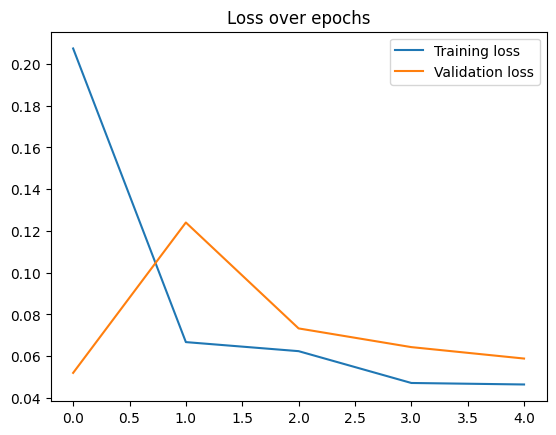

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Evaluating Results

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (9,) and arg 3 with shape (10,).

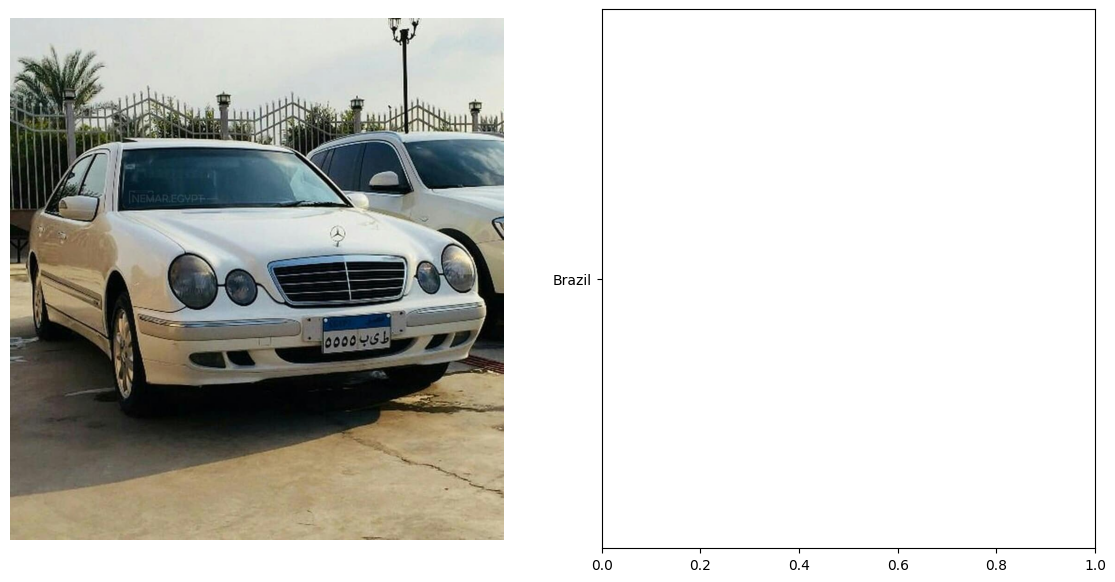

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/testData/Egypt/vehicle/1481.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor)

# Assuming dataset.classes gives the class names
class_names = dataset.classes() 
visualize_predictions(original_image, probabilities, class_names)

In [ ]:
from glob import glob
test_images = glob('/home/joshu/LPR-proj/data/LPRdatasets/vehicleImages/testData/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes()
    visualize_predictions(original_image, probabilities, class_names)

NameError: name 'preprocess_image' is not defined